### Reason for this notebook:

#### Despite the fact that we are properly gleaning order book data, it seems that there are still a few instances in every market where we temporarily have orders that are in cross. I want to find a way to resolve this


In [2]:
import requests
import json
from useful_functions import parse_all_book_updates, reconstruct_order_book
from OrderBook import OrderBook
from tqdm import tqdm
from collections import deque
import datetime as dt

In [3]:
market_data_filepath="btc_contracts-2/"
market_slug = "btc-updown-15m-1762310700"
#  cross points -> 
# [CROSS WARNING] Book crossed at 1762310828488: bid=0.34, ask=0.34
# [CROSS WARNING] Book crossed at 1762311493892: bid=0.19, ask=0.18
# [CROSS WARNING] Book crossed at 1762311497501: bid=0.31, ask=0.31
# [CROSS WARNING] Book crossed at 1762311567927: bid=0.03, ask=0.02

url = "https://gamma-api.polymarket.com/events"
response = requests.get(url, params={"slug": market_slug})
yes_token_id, no_token_id = json.loads(response.json()[0]['markets'][0]['clobTokenIds'])

# get order book updates from our historical data
messages = []
with open (f"{market_data_filepath}{market_slug}.jsonl") as f:
    for line in f:
        line_data = json.loads(line)
        messages.append(line_data)

order_book_updates = parse_all_book_updates(messages)
yes_book_updates = [update for update in order_book_updates if update['asset_id'] == yes_token_id]
no_book_updates = [update for update in order_book_updates if update['asset_id'] == no_token_id]

In [9]:
cid = "0x56f8de8878e825b73937be862fdcd7af2497c5b73df1dac0fd9113bf11846176"
from useful_functions import get_market_trades

t = get_market_trades(cid)
t

[{'proxyWallet': '0x47a35c8fdcdce37d9e19241d34e295fcb4911bce',
  'side': 'SELL',
  'asset': '101160920341113437254721927007904783071619510617577160798815803852851616980409',
  'conditionId': '0x56f8de8878e825b73937be862fdcd7af2497c5b73df1dac0fd9113bf11846176',
  'size': 1.06,
  'price': 0.99,
  'timestamp': 1761653725,
  'title': 'Bitcoin Up or Down - October 28, 8:00AM-8:15AM ET',
  'slug': 'btc-updown-15m-1761652800',
  'icon': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/BTC+fullsize.png',
  'eventSlug': 'btc-updown-15m-1761652800',
  'outcome': 'Down',
  'outcomeIndex': 1,
  'name': 'kkk829',
  'pseudonym': 'Excited-Choosing',
  'bio': '',
  'profileImage': '',
  'profileImageOptimized': '',
  'transactionHash': '0xb7b6e6d54711e0e0ec88596ac3398f496a19e7118a597fe9b85d95140b9e5906'},
 {'proxyWallet': '0xd13321a9af3ecb5fa33f9a36fc368c783c81d55f',
  'side': 'SELL',
  'asset': '101160920341113437254721927007904783071619510617577160798815803852851616980409',
  'conditionId': '0x

In [7]:
response.json()[0]['markets'][0]

{'id': '665623',
 'question': 'Bitcoin Up or Down - November 4, 9:45PM-10:00PM ET',
 'conditionId': '0xe569daa2fd97dc904cdfa459aaeaf3deaff263363b5433aa26bd0ffe15ceb9df',
 'slug': 'btc-updown-15m-1762310700',
 'resolutionSource': 'https://data.chain.link/streams/btc-usd',
 'endDate': '2025-11-05T03:00:00Z',
 'liquidity': '0',
 'startDate': '2025-11-04T23:47:14.977209Z',
 'image': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/BTC+fullsize.png',
 'icon': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/BTC+fullsize.png',
 'description': 'This market will resolve to "Up" if the Bitcoin price at the end of the time range specified in the title is greater than or equal to the price at the beginning of that range. Otherwise, it will resolve to "Down".\nThe resolution source for this market is information from Chainlink, specifically the BTC/USD data stream available at https://data.chain.link/streams/btc-usd.\nPlease note that this market is about the price according to Chainlink

In [6]:
yes_book_updates[:3]

[{'asset_id': '45124861563709344686399082185086427983705343456931722109903796989256200323333',
  'timestamp': 1762310722009,
  'price': 0.01,
  'size': 69672.0,
  'side': 'bid'},
 {'asset_id': '45124861563709344686399082185086427983705343456931722109903796989256200323333',
  'timestamp': 1762310722009,
  'price': 0.02,
  'size': 3732.5,
  'side': 'bid'},
 {'asset_id': '45124861563709344686399082185086427983705343456931722109903796989256200323333',
  'timestamp': 1762310722009,
  'price': 0.03,
  'size': 7034.33,
  'side': 'bid'}]

In [4]:
def reconstruct_order_book(stop_ts, book_updates):
    """
        Reconstruct order book up to a certain time
    """
    order_book = OrderBook()
    i = 0
    while yes_book_updates[i]['timestamp'] <= stop_ts:
        side = yes_book_updates[i]['side']
        price = yes_book_updates[i]['price']
        size = yes_book_updates[i]['size']
        timestamp = yes_book_updates[i]['timestamp']  
        order_book.update(side, price, size, timestamp)
        i += 1
    
    return order_book, i

#### Instance 1: 1762310828488

In [ ]:
ts = 1762310828488
order_book, i = reconstruct_order_book(ts, yes_book_updates)

In [ ]:
order_book.pretty_print()

In [ ]:
print(i) # next update past our stopping timestamp
print(yes_book_updates[i]) # 17321 -> ask to overwrite the bid of 0.34
print(yes_book_updates[i+1]) # 17322 -> immmediately changes bid size to 0

In [ ]:
order_book, i = reconstruct_order_book(ts+2, yes_book_updates)

In [ ]:
order_book.pretty_print()

##### For this instance, the fix came immediately afterward, so we're good

#### Instance 2: 1762311490065 -> same deal, order book just instantly gets set so that the new order that caused cross eliminated the new orders

In [ ]:

ts = 1762311490065 -1
order_book, i = reconstruct_order_book(ts, yes_book_updates)

In [ ]:
order_book.pretty_print()

In [ ]:
yes_book_updates[i]

In [ ]:
yes_book_updates[i+5]

In [32]:
dt.datetime.fromtimestamp(1762310828488/1000)

datetime.datetime(2025, 11, 4, 21, 47, 8, 488000)

#### Instance 3: 1762311493892

In [ ]:
ts = 1762311493892-1
order_book, i = reconstruct_order_book(ts, yes_book_updates)
order_book.pretty_print()

In [ ]:
print(yes_book_updates[i])
print(yes_book_updates[i+1])
print(yes_book_updates[i+2])
print(yes_book_updates[i+3])
print(yes_book_updates[i+4])
print(yes_book_updates[i+5])

In [ ]:
order_book, i = reconstruct_order_book(1762311493893, yes_book_updates)

In [ ]:
order_book.pretty_print()

In [ ]:
# checking what the order book looks like a second later
order_book, i = reconstruct_order_book(1762311493893+1000, yes_book_updates)

# WHAT I SAW -> that order that crossed the spread got CLEARED OUT

In [ ]:
order_book, i = reconstruct_order_book(1762311493893+400, yes_book_updates)
# 200 ms later it got added to up to 135 at 0.19
# 300 ms later it was down to just 120
# 400 ms later it was gone completely

In [ ]:
order_book.pretty_print()

### New Idea, let's plot the order book at every timestamp to see what we can do with the microstructure

In [3]:
timestamps = sorted(list({update['timestamp'] for update in yes_book_updates}))
order_book_prices_t = []
order_book = OrderBook()

market_update_queue = deque(yes_book_updates)

for time in tqdm(timestamps):
    # not the most efficient implementation, but ok for now
    # order_book, i = reconstruct_order_book(time, yes_book_updates)
    
    market_updates = []
    while market_update_queue and market_update_queue[0]['timestamp'] == time:
        market_update = market_update_queue.popleft()
        market_updates.append(market_update)

    order_book.batch_update(market_updates)

    for price, size in order_book.bids.items():
        order_book_prices_t.append({
            'timestamp': time,
            'price': price,
            'size': size,
            'side': 'bid'
        })

    for price, size in order_book.asks.items():
        order_book_prices_t.append({
            'timestamp': time,
            'price': price,
            'size': size,
            'side': 'ask'
        })

 28%|██▊       | 16094/58087 [00:00<00:00, 55022.94it/s]

[CROSS WARNING] Book crossed at 1762310828488: bid=0.34, ask=0.34


100%|██████████| 58087/58087 [00:01<00:00, 56876.38it/s]


In [10]:

import matplotlib.pyplot as plt
from matplotlib.widgets import Button, TextBox
import pandas as pd
book_updates = pd.DataFrame(order_book_prices_t)
book_updates = book_updates.sort_values(["timestamp", "price"])
timestamps = sorted(book_updates['timestamp'].unique())
order_book_prices_t = sorted(order_book_prices_t, key = lambda x: (x['timestamp'], x['price']))
    

In [38]:
plot_data_by_time = {}
for ts, data in tqdm(book_updates.groupby("timestamp")):

    bid_prices = []
    bid_sizes = []
    ask_prices = []
    ask_sizes = []
    bid_df = data[data['side'] == 'bid']
    for i, row in bid_df.sort_values(by="price").iterrows():
        bid_prices.append(row['price'])
        bid_sizes.append(row['size'])
    
    ask_df = data[data['side'] == 'ask']
    for i, row in ask_df.sort_values(by="price", ascending=False).iterrows():
        ask_prices.append(row['price'])
        ask_sizes.append(row['size'])
    
    colors = ["green"]*len(bid_prices) + ["red"]*len(ask_prices)
    
    plot_data_by_time[ts] = (bid_prices+ask_prices, bid_sizes+ask_sizes, colors)

100%|██████████| 58087/58087 [01:25<00:00, 677.87it/s]


In [1]:
book_updates

NameError: name 'book_updates' is not defined

In [42]:
max(plot_data_by_time.keys()), min(plot_data_by_time.keys())

(1762311610149, 1762310722009)

In [44]:
dt.datetime.fromtimestamp(1762310722009/1000), dt.datetime.fromtimestamp(1762311610149/1000)

(datetime.datetime(2025, 11, 4, 21, 45, 22, 9000),
 datetime.datetime(2025, 11, 4, 22, 0, 10, 149000))

In [9]:
import numpy as np

In [45]:
import requests
url = "https://data-api.polymarket.com/trades"
params = {
    "limit": 500,
    "offset": 0,
    # "market": ['0x56f8de8878e825b73937be862fdcd7af2497c5b73df1dac0fd9113bf11846176'],
    "market": ["0x6f5a9ac3e56348995af1f871fda6e5b301375859b3062b97aa968816aceed60f"]
    # "takerOnly": "true",
}
response = requests.get(url, params=params)
trades = []
while len(response.json()):
    trades += response.json()
    params['offset'] += 500
    response = requests.get(url, params=params)

In [48]:
trades

[{'proxyWallet': '0xfcd2fde8e69005fb6ef78537a2646ad030b26535',
  'side': 'BUY',
  'asset': '98609621745459687469557651541160413948833598590564588692597826915978981517946',
  'conditionId': '0x6f5a9ac3e56348995af1f871fda6e5b301375859b3062b97aa968816aceed60f',
  'size': 5.99,
  'price': 0.999,
  'timestamp': 1761689105,
  'title': 'Ethereum Up or Down - October 28, 3:30PM-3:45PM ET',
  'slug': 'eth-updown-15m-1761679800',
  'icon': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/ETH+fullsize.jpg',
  'eventSlug': 'eth-updown-15m-1761679800',
  'outcome': 'Up',
  'outcomeIndex': 0,
  'name': 'un3xp3C73d1Y64d200k5',
  'pseudonym': 'Zigzag-Breakpoint',
  'bio': '',
  'profileImage': '',
  'profileImageOptimized': '',
  'transactionHash': '0xc9ac48c251344f7cacd6141063f2f6b48ee7c4285c3e15a8015b0ca6d3e1a8ff'},
 {'proxyWallet': '0xee7c15f0a88ecd918cfe0389e985f2a3c782807a',
  'side': 'BUY',
  'asset': '98609621745459687469557651541160413948833598590564588692597826915978981517946',
  'condit

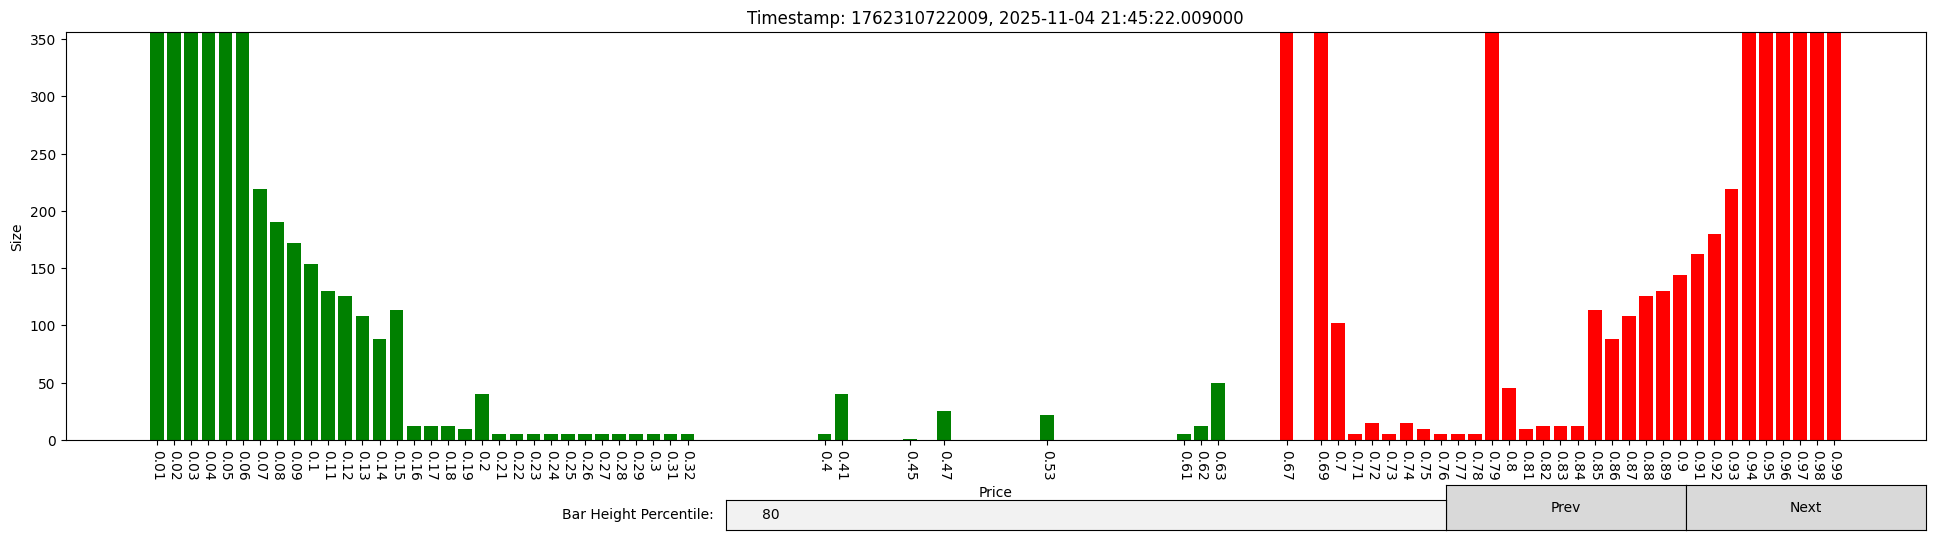

In [50]:
fig, ax = plt.subplots(figsize=(24,6))
plt.subplots_adjust(bottom=0.2)

current_index = 0
bars = None
max_bar_percentile = 80

def update_plot(idx):
    global bars
    global max_bar_percentile
    ax.clear()
    ts = timestamps[idx]
    prices, sizes, colors = plot_data_by_time[ts]
    bars = ax.bar(prices, sizes, color=colors, width=0.008)
    ax.set_title(f"Timestamp: {timestamps[idx]}, {dt.datetime.fromtimestamp(ts/1000)}")
    ax.set_xlabel("Price")
    ax.set_ylabel("Size")
    ax.set_xticks(prices) 
    ax.set_xticklabels(prices, rotation=-90)
    ax.set_ylim(top=np.percentile(sizes, max_bar_percentile))
    plt.draw()

def next_frame(event):
    global current_index
    current_index = ((current_index + 1) % len(timestamps))
    update_plot(current_index)

def prev_frame(event):
    global current_index
    current_index = ((current_index - 1) % len(timestamps))
    update_plot(current_index)

def update_max_bar(text):
    global max_bar_percentile
    global current_index
    try:
        p = float(text)
        if not (0 < p <= 100):
            raise ValueError
        
        max_bar_percentile = p
        update_plot(current_index)
    except ValueError:
        print("Please enter a valid number between 0 and 100.")

# add buttons
ax_prev_button = plt.axes([0.7, 0.05, 0.1, 0.075])
prev_btn = Button(ax_prev_button, 'Prev')
prev_btn.on_clicked(prev_frame)
ax_next_button = plt.axes([0.8, 0.05, 0.1, 0.075])
next_btn = Button(ax_next_button, 'Next')
next_btn.on_clicked(next_frame)
# add text box
axbox = plt.axes([0.4, 0.05, 0.3, 0.05])  # [left, bottom, width, height]
text_box = TextBox(axbox, "Bar Height Percentile: ", initial=str(max_bar_percentile))
text_box.on_submit(update_max_bar)

# initial plot
update_plot(current_index)

plt.show()

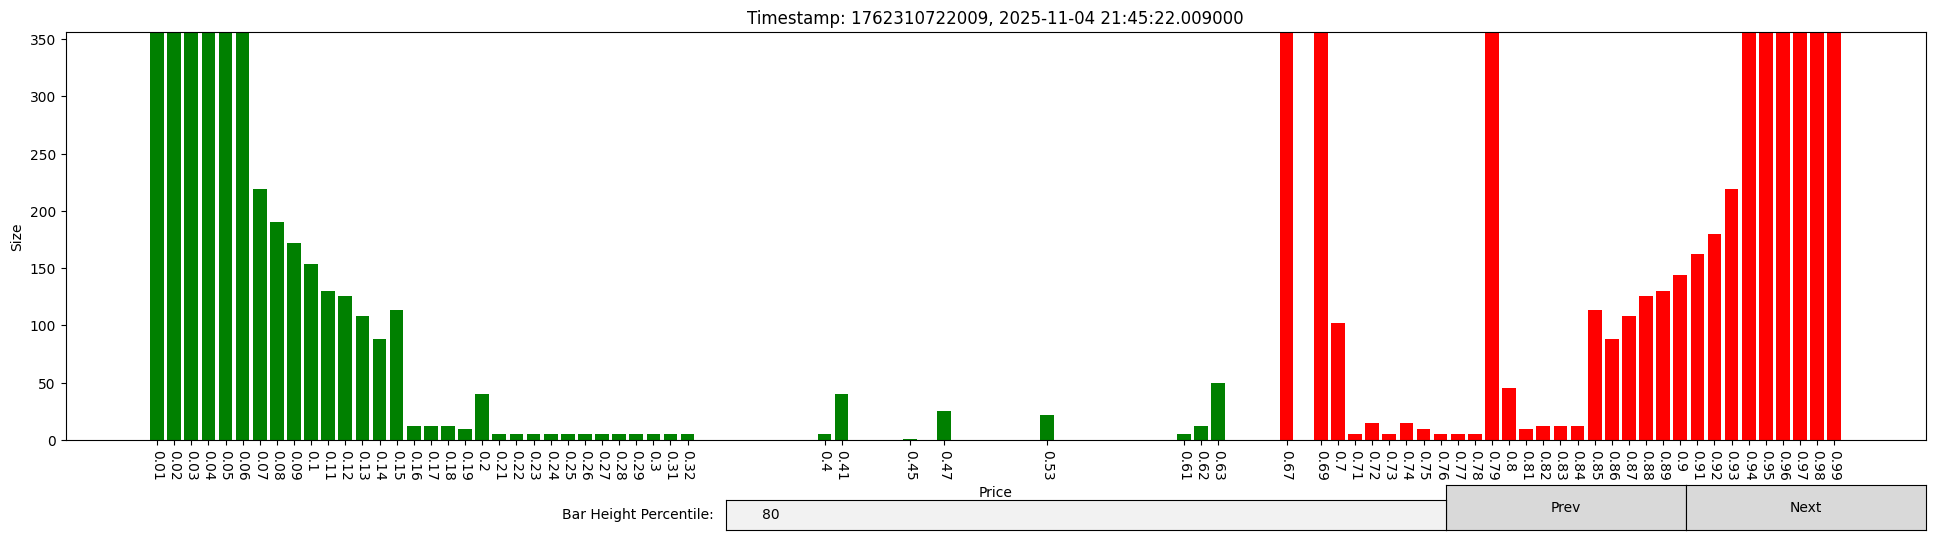

In [51]:
fig, ax = plt.subplots(figsize=(24,6))
plt.subplots_adjust(bottom=0.2)

current_index = 0
bars = None
max_bar_percentile = 80

def update_plot(timestamps, plot_data_by_time, idx):
    global bars
    global max_bar_percentile
    ax.clear()
    ts = timestamps[idx]
    prices, sizes, colors = plot_data_by_time[ts]
    bars = ax.bar(prices, sizes, color=colors, width=0.008)
    ax.set_title(f"Timestamp: {timestamps[idx]}, {dt.datetime.fromtimestamp(ts/1000)}")
    ax.set_xlabel("Price")
    ax.set_ylabel("Size")
    ax.set_xticks(prices) 
    ax.set_xticklabels(prices, rotation=-90)
    ax.set_ylim(top=np.percentile(sizes, max_bar_percentile))
    plt.draw()

def next_frame(event):
    global current_index
    current_index = ((current_index + 1) % len(timestamps))
    update_plot(current_index)

def prev_frame(event):
    global current_index
    current_index = ((current_index - 1) % len(timestamps))
    update_plot(current_index)

def update_max_bar(text):
    global max_bar_percentile
    global current_index
    try:
        p = float(text)
        if not (0 < p <= 100):
            raise ValueError
        
        max_bar_percentile = p
        update_plot(current_index)
    except ValueError:
        print("Please enter a valid number between 0 and 100.")

# add buttons
ax_prev_button = plt.axes([0.7, 0.05, 0.1, 0.075])
prev_btn = Button(ax_prev_button, 'Prev')
prev_btn.on_clicked(prev_frame)
ax_next_button = plt.axes([0.8, 0.05, 0.1, 0.075])
next_btn = Button(ax_next_button, 'Next')
next_btn.on_clicked(next_frame)
# add text box
axbox = plt.axes([0.4, 0.05, 0.3, 0.05])  # [left, bottom, width, height]
text_box = TextBox(axbox, "Bar Height Percentile: ", initial=str(max_bar_percentile))
text_box.on_submit(update_max_bar)

# initial plot
update_plot(current_index)

plt.show()

In [60]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, TextBox
import numpy as np
import datetime as dt

class InteractiveBarPlot:
    def __init__(self, timestamps:list, plot_data_by_time:dict, initial_jump=5, initial_percentile=80):
        '''
            timestamps is a list of all of the timestamps present in the order book data
            plot_data_by_time is a dict with timestamp as the key and a tuple of (prices, sizes, colors) as the value
        
        '''
        self.timestamps = timestamps
        self.plot_data_by_time = plot_data_by_time
        self.current_index = 0
        self.jump_amount = initial_jump
        self.max_bar_percentile = initial_percentile

        # Create figure and axis
        self.fig, self.ax = plt.subplots(figsize=(24, 6))
        plt.subplots_adjust(bottom=0.2)

        # Create buttons and text boxes
        self._create_widgets()

        # Initial plot
        self.update_plot(self.current_index)

        plt.show()

    def update_plot(self, idx):
        """Redraw the bar chart for a given timestamp index."""
        self.ax.clear()
        ts = self.timestamps[idx]
        prices, sizes, colors = self.plot_data_by_time[ts]

        self.ax.bar(prices, sizes, color=colors, width=0.008)
        self.ax.set_title(f"Timestamp: {ts}, {dt.datetime.fromtimestamp(ts/1000)}")
        self.ax.set_xlabel("Price")
        self.ax.set_ylabel("Size")
        self.ax.set_xticks(prices)
        self.ax.set_xticklabels(prices, rotation=-90)
        max_shown_y = np.percentile(sizes, self.max_bar_percentile)
        self.ax.set_ylim(bottom=0, top=max_shown_y)

        theo_x = 0.55
        self.ax.axvline(theo_x, ymin=0, ymax=max_shown_y, color="gold", linestyle="--", linewidth=2, label="Theo")
        self.ax.text(theo_x, max_shown_y * 0.95, f"Theo: {theo_x:.4f}",
                     rotation=90, va='top', ha='right', color='black', fontsize=10)

        self.fig.canvas.draw_idle()

    def next_frame(self, event):
        """Move forward by jump_amount frames."""
        self.current_index = (self.current_index + self.jump_amount) % len(self.timestamps)
        self.update_plot(self.current_index)

    def prev_frame(self, event):
        """Move backward by jump_amount frames."""
        self.current_index = (self.current_index - self.jump_amount) % len(self.timestamps)
        self.update_plot(self.current_index)

    def update_jump_amount(self, text):
        """Update how many frames to jump per button press."""
        try:
            value = int(text)
            if value <= 0:
                raise ValueError
            self.jump_amount = value
        except ValueError:
            print("Jump amount must be a positive integer")

    def update_max_bar(self, text):
        """Update the percentile for Y-axis scaling."""
        try:
            value = float(text)
            if not (0 < value <= 100):
                raise ValueError
            self.max_bar_percentile = value
            self.update_plot(self.current_index)
        except ValueError:
            print("Please enter a valid number between 0 and 100.")

    def _create_widgets(self):
        """Set up the interactive UI elements."""
        # Buttons
        ax_prev = plt.axes([0.7, 0.05, 0.1, 0.075])
        ax_next = plt.axes([0.8, 0.05, 0.1, 0.075])
        prev_btn = Button(ax_prev, 'Prev')
        next_btn = Button(ax_next, 'Next')
        prev_btn.on_clicked(self.prev_frame)
        next_btn.on_clicked(self.next_frame)

        # Jump amount text box
        ax_jump = plt.axes([0.55, 0.05, 0.03, 0.05])
        jump_box = TextBox(ax_jump, "Index Jump: ", initial=str(self.jump_amount))
        jump_box.on_submit(self.update_jump_amount)

        # Max bar percentile text box
        ax_bar = plt.axes([0.2, 0.05, 0.03, 0.05])
        bar_box = TextBox(ax_bar, "Bar %: ", initial=str(self.max_bar_percentile))
        bar_box.on_submit(self.update_max_bar)

# Usage example:
# plot = InteractiveBarPlot(timestamps, plot_data_by_time)


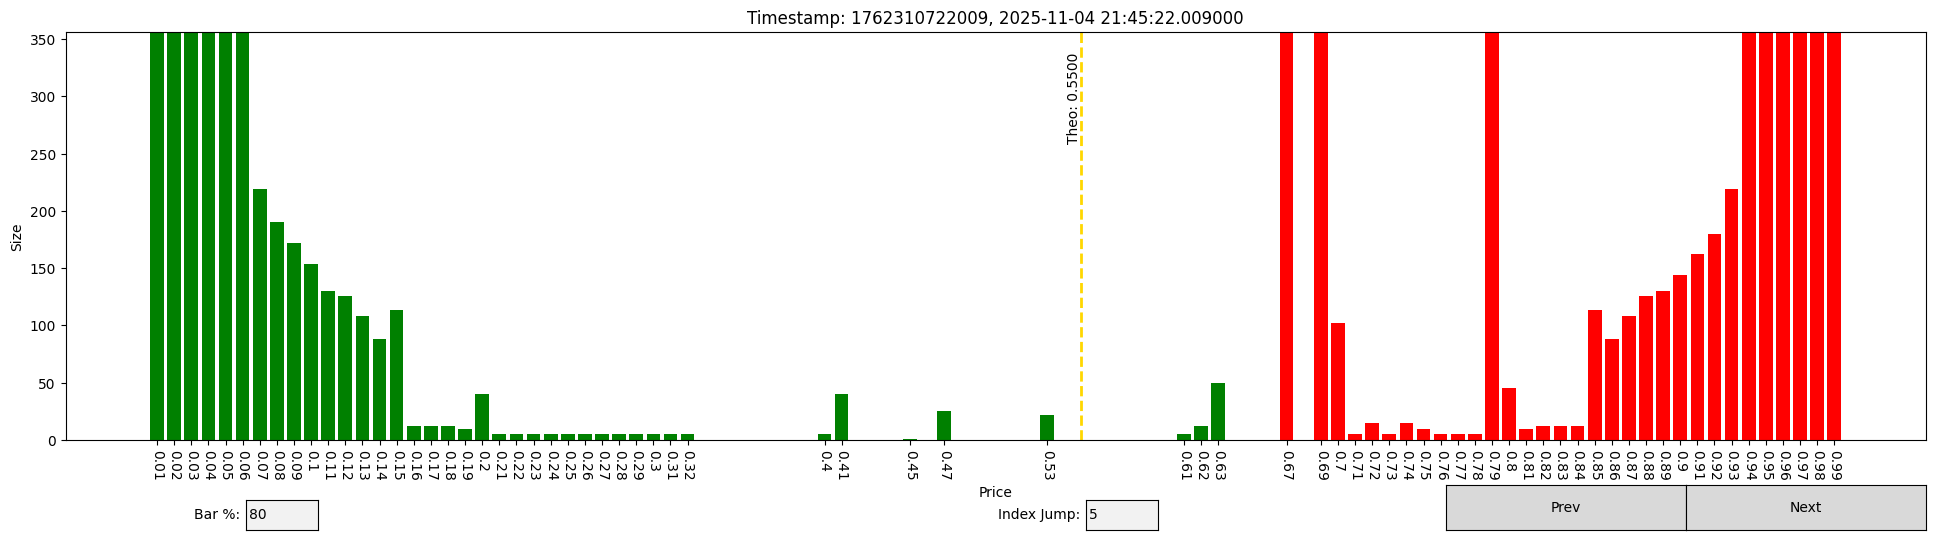

In [61]:
plot = InteractiveBarPlot(timestamps, plot_data_by_time)

In [ ]:
# PLOT FOR JUST ONE TIMESTAMP
import plotly.graph_objects as go

t, book = next(iter(book_updates.groupby("timestamp")))
bids = book[book["side"]== "bid"]
asks = book[book["side"] == "ask"]

bid_depth = bids.groupby("price")["size"].sum()
ask_depth = asks.groupby("price")["size"].sum()

fig = go.Figure()

fig.add_bar(x=list(bid_depth.index), y=list(bid_depth.values), name="Bids", marker_color="green")
fig.add_bar(x=list(ask_depth.index), y=list(ask_depth.values), name="Asks", marker_color="red")

fig.update_layout(
    title=f"Order Book Depth @ {t}",
    xaxis=dict(title="Price (normalized 0-1)"),
    yaxis=dict(title="Order Size"),
    barmode="overlay"
)
fig.show()
